# DwarfGAN - Deep Learning based Map Design for Dwarf Fortress

### Setup and Imports

In [1]:
# imports
from keras.layers import Add, Concatenate, Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D, LayerNormalization
from keras.layers.experimental import preprocessing
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
from keras.losses import binary_crossentropy, Loss
from keras import metrics
from functools import partial
from tensorflow import keras

import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import pathlib
import tensorflow as tf
import io
import random

#!pip install boto3
import boto3 as b3 


print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

############### CONFIG ###################

# model name
model_name = 'dwarfganWGANGPR09Tiles'
# folder path to input files (map images)
fpath = r'/data2/input'
# folder path to tensorboard output
tboard_dir = '/data2/output/tensorboard'
# folder path for saved model output
out_model_dir = '/data2/output/models'
# folder for images to be saved during training
out_img_dir = '/data2/output/images'
# frequency of checkpoint saves (images, model weights) in epochs
CHECKPOINT = 50
# use skip connections (additive)?
SKIP_ADD = False
SKIP_CONCAT = False
LATENT_DIM = 128
EPOCHS = 1000 
#BATCH_PER_EPOCH = 20
# pre-processed (cropped) images are 1024x1024. We will later resize the images to 256x256 due to memory restrictions.
IMAGE_SIZE = (12,12)
BATCH_SIZE = 128
CRITIC_FACTOR = 5 # number of times the critic is trained more often than the generator. Recommended = 5
GRADIENT_PENALTY_WEIGHT = 10
RELU_SLOPE_C = 0.2
RELU_SLOPE_G = 0.2
DROPOUT_C = 0.3
MOMENTUM_G = 0.9
CRIT_LR = 0.0003 # Adjusted learning rates according to two time-scale update rule (TTUR), see Heusel et al., 2017
GEN_LR = 0.0001

# NOTE: all extracted map PNGs have been saved on a separate virtual disk mapped to '/data' of the virtual machine in use
data_dir = pathlib.Path(fpath + '/maps')
imgs = list(data_dir.glob('*.png'))

##########################################

2.3.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


### Data Load and Train / Validation Split

The map images sourced from the DFMA come in a variety of dimensions. In order to create sample images with constant dimensions, as required by tensors, the 100k input samples were run through a python script to randomly crop 10 1024 x 1024 areas per picture. Of those cropped (sub-)images, only the ones which contain structures were retained. This was achieved by filtering out image crops which only contained two or less different colors. With that, the logic mainly filterd out crops which only contained black. This process resulted in 700'000+ (sub-)image samples.

In [32]:
# use pre-processed (cropped) 128 x 128 images
data_dir = pathlib.Path(fpath + '/ascii_crops_12/maps')
imgs = list(data_dir.glob('*.png'))
print(f'There are {str(len(imgs))} cropped image samples available')

There are 12068 cropped image samples available


In [3]:
# show example sample image (cropped to 128x128)
print('A random sample input image:')
PIL.Image.open(imgs[random.randint(0,len(imgs))])

A random sample input image:


In [33]:


# creating keras datasets for training and validation - refer to https://www.tensorflow.org/tutorials/images/classification
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(  fpath+'/ascii_crops_12',
                                                                      image_size=IMAGE_SIZE, 
                                                                      batch_size=BATCH_SIZE, 
                                                                      labels=[1.] * len(imgs), # setting all labels to 1.0 (for 'real') as float32
                                                                      #label_mode=None, # yields float32 type labels
                                                                      seed=1234 #,
                                                                   )

# refer to https://www.tensorflow.org/tutorials/images/classification
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = dataset_train.cache().prefetch(buffer_size=BATCH_SIZE)
#val_ds = dataset_val.cache().prefetch(buffer_size=BATCH_SIZE)
#val_ds = None

Found 12068 files belonging to 1 classes.


In [34]:
N_TRAINING = 12068 # = 20% of total samples

### Check Random Sample from Dataset

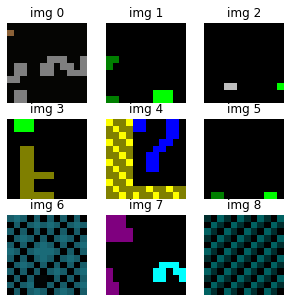

In [35]:
# Check random images from prepared batches
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1): # take one batch. Here batch_size = 128 examples per batch
    for i in range(9): # show first 9 images of batch
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f'img {i}')
        plt.axis('off')

# UPDATED Model Definition

Generally the following changes have been implemented to the architectures:

### RUN09

- instead of generating full maps, this model focuses on learning to recreate single tiles which represent the different objects/elements in the game world
- implemented secondary input for both critic and generator which introduces the single tiles cropped from the tileset files (12x10) as a 12x10x256 vector (256 different 12x10 tiles) 

### Discriminator

In [248]:


def discriminator_model():

    # DISCRIMINATOR
    # set input variables to variable width + height. Will be cropped in preprocessing [CURRENTLY FIXED TO 256x256]
    input_dim = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

    # Input
    d_input = Input(shape=input_dim, name='Discriminator_Input')
    
    

    # ---- REMOVED FOR 256x256 NETWORK ----------
    # Keras-based preprocessing. Alternative: RandomCrop()
    # use smart_resizing?
    #x = tf.keras.preprocessing.image.smart_resize(d_input, (1024, 1024))
    #x = preprocessing.Resizing(width=512, 
    #                           height=512, 
    #                           name='Preprocessing_Resize'
    #                          )(d_input) # Resize to 512 x 512 images

    #we crop the images to 12x10 to match the tile dimensions
    x = preprocessing.RandomCrop(height=12, 
                                width=10, 
                                name = 'Preprocessing_RandomCrop'
                               )(d_input)

    x = preprocessing.Rescaling(scale=1./127.5, 
                                offset=-1,
                                name='Preprocessing_Rescale'
                               )(x) # Rescale values from [0,255] to [-1,1] see https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling


    # START TILES INPUT
    tiles_input = Input(shape=(12,10,256), name='Tiles_Input')
    
    tiles = preprocessing.Rescaling(scale=1./127.5, 
                                offset=-1,
                                name='Preprocessing_Rescale_Tiles'
                               )(tiles_input) # Rescale values from [0,255] to [-1,1] see https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling


    
    #tiles = Conv2D(filters=256, kernel_size=(1,1), strides=1)(tiles)
    
    x = Concatenate()([x, tiles])
    # END TILES INPUT
    
    
    # Conv2D Layer 0
    x = Conv2D(
            filters = 64,
            kernel_size = (3,3), 
            strides = 1,
            padding = 'same',
            kernel_initializer = RandomNormal(mean=0., stddev=0.02),
            name = 'Discriminator_Conv2D_Layer_0'
    )(x)
    
    # Activation 0 - Leaky ReLU
    x = LeakyReLU(alpha = RELU_SLOPE_C, name='Activation_0')(x)
    
    
    # Conv2D Layer 1
    x = Conv2D(
            filters = 128,
            kernel_size = 3,
            strides = 2,
            padding = 'same',
            kernel_initializer = RandomNormal(mean=0., stddev=0.02),
            name = 'Discriminator_Conv2D_Layer_1'
    )(x)

    # BatchNorm Layer 1
    #x = BatchNormalization()(x)

    # Activation 1 - Leaky ReLU
    x = LeakyReLU(alpha = RELU_SLOPE_C, name='Activation_1')(x)

    # Dropout 1
    x = Dropout(rate = DROPOUT_C)(x)



    # Conv2D Layer 2
    x = Conv2D(
            filters = 256,
            kernel_size = 3,
            strides = 2,
            padding = 'same',
            name = 'Discriminator_Conv2D_Layer_3',
            kernel_initializer = RandomNormal(mean=0., stddev=0.02)
    )(x)

    # BatchNorm Layer 2
    #x = BatchNormalization()(x)

    # Activation 2 - Leaky ReLU
    x = LeakyReLU(alpha = RELU_SLOPE_C, name='Activation_3')(x)


    # OUTPUT
    x = Flatten()(x)
    #x = Dropout(DROPOUT_C)(x)
    
    d_output = Dense(1, 
                     #activation='sigmoid', 
                     kernel_initializer = RandomNormal(mean=0, stddev=0.02) # random initialization of weights with normal distribution around 0 with small SD
                    )(x)



    # Discriminator Model intialization
    discriminator = Model([d_input, tiles_input], d_output, name='Discriminator')
    
    
    
    return discriminator



In [249]:
disc = discriminator_model()
disc.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Discriminator_Input (InputLayer [(None, 12, 12, 3)]  0                                            
__________________________________________________________________________________________________
Preprocessing_RandomCrop (Rando (None, 12, 10, 3)    0           Discriminator_Input[0][0]        
__________________________________________________________________________________________________
Tiles_Input (InputLayer)        [(None, 12, 10, 256) 0                                            
__________________________________________________________________________________________________
Preprocessing_Rescale (Rescalin (None, 12, 10, 3)    0           Preprocessing_RandomCrop[0][0]   
______________________________________________________________________________________

### Generator

In [255]:
def generator_model():

    # GENERATOR

    # set input variable dimensions. Here we will start out with a vector of length 100 for each sample (sampled from a normal distribution, representing the learned latent space)
    input_dim = (LATENT_DIM)

    # Input
    g_input = Input(shape=input_dim, name='Generator_Input')

    # Dense Layer 1
    x = Dense(np.prod([3,3,512]), kernel_initializer = RandomNormal(mean=0., stddev=0.02), 
              use_bias=False)(g_input) # use_bias=False see https://keras.io/examples/generative/wgan_gp/

    # Batch Norm Layer 1
    x = BatchNormalization(momentum = MOMENTUM_G)(x)
    
    # Activation Layer 1
    x = LeakyReLU(alpha=RELU_SLOPE_G)(x) # trying leaky ReLU instead of Activation('relu')(x)

    # Reshape into 3D tensor
    x = Reshape((3,3,512))(x)

    # Upsampling Layer 1 + Conv2D Layer1
    x = Conv2DTranspose(filters=512, kernel_size=(3,3), padding='same', strides=(2,2), 
                        kernel_initializer = RandomNormal(mean=0., stddev=0.02), use_bias=False)(x)
    
    
    # Batch Norm Layer 2
    #x = BatchNormalization(momentum = MOMENTUM_G)(x)
    x = LayerNormalization()(x) # performs pixel-wise normalization across all channels
    
    # Activation Layer 2
    x = LeakyReLU(alpha=RELU_SLOPE_G)(x) # trying leaky ReLU instead of Activation('relu')(x)
    

    x = Conv2DTranspose(filters=256, kernel_size=(3,3), padding='same', strides=(2,2), 
                        kernel_initializer = RandomNormal(mean=0., stddev=0.02), use_bias=False)(x)
    
    
    # Batch Norm Layer 2
    #x = BatchNormalization(momentum = MOMENTUM_G)(x)
    x = LayerNormalization()(x) # performs pixel-wise normalization across all channels
    
    # Activation Layer 2
    x = LeakyReLU(alpha=RELU_SLOPE_G)(x) # trying leaky ReLU instead of Activation('relu')(x)
    

    x = Conv2DTranspose(filters=128, kernel_size=(3,3), padding='same', strides=(1,1), 
                        kernel_initializer = RandomNormal(mean=0., stddev=0.02), use_bias=False)(x)
    
    # START TILES
    tiles_input = Input(shape=(12,10,256), name='Tiles_Input')
    tiles = preprocessing.Resizing(width=12, height=12)(tiles_input)
    
    x = Concatenate()([x, tiles])
    
    # END TILES
    # Batch Norm Layer 2
    #x = BatchNormalization(momentum = MOMENTUM_G)(x)
    x = LayerNormalization()(x) # performs pixel-wise normalization across all channels
    
    # Activation Layer 2
    x = LeakyReLU(alpha=RELU_SLOPE_G)(x) # trying leaky ReLU instead of Activation('relu')(x)
    
    
    # reduce output dimensions via 1x1 convolution
    x = Conv2D(filters=3, kernel_size=(1,1), padding='same', strides=(1,1),
               kernel_initializer = RandomNormal(mean=0., stddev=0.02), use_bias=False)(x)
        
    # tanh activation layer to scale values to [-1:1]
    x = Activation('tanh')(x)
    
    # Batch Norm Layer 7
    #x = BatchNormalization(momentum = MOMENTUM_G)(x)
    #x = LayerNormalization()(x) # performs pixel-wise normalization across all channels

    # Output - Rescale Values back to [0:255] since the discriminator will automatically rescale back down to [-1:1] as part of the pre-processing pipeline
    g_output = (255 / 2) * (x + 1) 


    # Generator Model initialization
    generator = Model([g_input, tiles_input], g_output, name='Generator')
    
    
    return generator


In [256]:
gen = generator_model()
gen.summary()

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Generator_Input (InputLayer)    [(None, 128)]        0                                            
__________________________________________________________________________________________________
dense_40 (Dense)                (None, 4608)         589824      Generator_Input[0][0]            
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 4608)         18432       dense_40[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_54 (LeakyReLU)      (None, 4608)         0           batch_normalization_18[0][0]     
__________________________________________________________________________________________

### Load Tiles

We load the 256 split 12x10 tiles into a (12,10,256) numpy array to feed to the network at training time.

In [279]:
tiles = []

data_dir = pathlib.Path('/data2/input/tiles/800x600/')
imgs = list(data_dir.glob('*.png'))

# show example sample image (cropped to 128x128)
print('A random sample input image:')
PIL.Image.open(imgs[random.randint(0,len(imgs))])

print('Putting together a (12,10,256) np.array')
for img in imgs:
    tiles.append(np.asarray(PIL.Image.open(img)).astype('uint8'))
    

ds_tiles = np.array(tiles)
ds_tiles = ds_tiles.reshape((12,10,256))
print(f'Created numpy array with shape: {ds_tiles.shape}')



tiles_ds = tf.data.Dataset.from_tensor_slices(ds_tiles)

tiles_ds = tiles_ds.cache().prefetch(buffer_size=BATCH_SIZE)

A random sample input image:
Putting together a (12,10,256) np.array
Created numpy array with shape: (12, 10, 256)


### WGAN-GP (Full) Model Compilation

Before we compile the models, we need to implement a custom loss function which uses the Wasserstein distance and a gradient penalty term in order to ensure 1 Lipschitz constraints are followed. A WGAN with GP further involves a slightly more complicated training process which trains the critic (discriminator without sigmoid activation function) by feeding three different kinds of images:

1. real images (i.e. available samples)
2. 'fake' images (i.e. constructed by the generator)
3. random interpolations between real and fake images (i.e. random samples interpolated from values between the fake and real images)

The full training process of a critic is depicted below (source: Foster, 2019, p. 122):

<div align="center">
    <img src="wgan_gp_critic_training.png"></img>
    <i>Computational Graph for one Discriminator Training Epoch. (Source: Foster, 2019, p.122)</i>
</div>

The implementation below roughly follows the OOP-based framework set by keras see https://keras.io/examples/generative/wgan_gp/

In [272]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope(): 

    critic = discriminator_model()
    generator = generator_model()

    class WGANGP(keras.Model):
        def __init__(
            self,
            critic,
            generator,
            latent_dim,
            tensorboard_callback,
            critic_extra_steps=5,
            gp_weight=10.0
        ):
            super(WGANGP, self).__init__()
            self.critic = critic
            self.generator = generator
            self.latent_dim = latent_dim
            self.tensorboard_callback = tensorboard_callback
            self.d_steps = critic_extra_steps
            self.gp_weight = gp_weight
            

        def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
            super(WGANGP, self).compile()
            self.d_optimizer = d_optimizer
            self.g_optimizer = g_optimizer
            self.d_loss_fn = d_loss_fn
            self.g_loss_fn = g_loss_fn

        def gradient_penalty(self, batch_size, real_images, fake_images):
            """ Calculates the gradient penalty.

            This loss is calculated on an interpolated image
            and added to the discriminator loss.
            """
            # Get the interpolated image
            alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
            diff = fake_images - real_images
            interpolated = real_images + alpha * diff

            with tf.GradientTape() as gp_tape:
                gp_tape.watch(interpolated)
                # 1. Get the discriminator output for this interpolated image.
                pred = self.critic(interpolated, training=True)

            # 2. Calculate the gradients w.r.t to this interpolated image.
            grads = gp_tape.gradient(pred, [interpolated])[0]
            # 3. Calculate the norm of the gradients.
            norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
            gp = tf.reduce_mean((norm - 1.0) ** 2)
            return gp

        def train_step(self, real_images):
            #checking whether we handed a tuple of (numpy) data to .fit().
            #if not, the data must be a tf.data.Dataset generator that yields batches of datasets (data, labels)
            if isinstance(real_images, tuple):
                real_images = real_images[0]

            # Get the batch size
            batch_size = tf.shape(real_images)[0]

            # For each batch, we are going to perform the
            # following steps as laid out in the original paper:
            # 1. Train the generator and get the generator loss
            # 2. Train the discriminator and get the discriminator loss
            # 3. Calculate the gradient penalty
            # 4. Multiply this gradient penalty with a constant weight factor = self.discriminator_extra_steps = 5 (default value)
            # 5. Add the gradient penalty to the discriminator loss
            # 6. Return the generator and discriminator losses as a loss dictionary

            # Train the discriminator first. The original paper recommends training
            # the discriminator for `x` more steps (typically 5) as compared to generator
            
            # set tensorboard model
            self.tensorboard_callback.set_model(self.critic)
            
            for i in range(self.d_steps):
                # Get the latent vector
                random_latent_vectors = tf.random.normal(
                    shape=(batch_size, self.latent_dim)
                )
                with tf.GradientTape() as tape:
                    # Generate fake images from the latent vector
                    fake_images = self.generator(random_latent_vectors, training=True)
                    # Get the logits for the fake images
                    fake_logits = self.critic(fake_images, training=True)
                    # Get the logits for the real images
                    real_logits = self.critic(real_images, training=True)

                    # Calculate the discriminator loss using the fake and real image logits
                    d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                    # Calculate the gradient penalty
                    gp = self.gradient_penalty(batch_size, real_images, fake_images)
                    # Add the gradient penalty to the original discriminator loss
                    d_loss = d_cost + gp * self.gp_weight

                # Get the gradients w.r.t the discriminator loss
                d_gradient = tape.gradient(d_loss, self.critic.trainable_variables)
                # Update the weights of the discriminator using the discriminator optimizer
                self.d_optimizer.apply_gradients(
                    zip(d_gradient, self.critic.trainable_variables)
                )

            # Train the generator
            # set tensorboard model
            self.tensorboard_callback.set_model(self.generator)
            
            # Get the latent vector
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                # Generate fake images using the generator
                generated_images = self.generator(random_latent_vectors, training=True)
                # Get the discriminator logits for fake images
                gen_img_logits = self.critic(generated_images, training=True)
                # Calculate the generator loss
                g_loss = self.g_loss_fn(gen_img_logits)

            # Get the gradients w.r.t the generator loss
            gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
            # Update the weights of the generator using the generator optimizer
            self.g_optimizer.apply_gradients(
                zip(gen_gradient, self.generator.trainable_variables)
            )
            return {"d_loss": d_loss, "g_loss": g_loss}
        
    class GANMonitor(keras.callbacks.Callback):
        def __init__(self, num_img=5, latent_dim=128):
            self.num_img = num_img
            self.latent_dim = latent_dim

        def on_epoch_end(self, epoch, logs=None): #on_epoch_end(self, epoch, logs=None):
            '''
            random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
            generated_images = self.model.generator(random_latent_vectors)
            #generated_images = (generated_images * 127.5) + 127.5

            for i in range(self.num_img):
                img = generated_images[i].numpy()
                img = keras.preprocessing.image.array_to_img(img)
                img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))
            '''
            
            # Sample generator output for num_img images
            noise = np.random.normal(0, 1, (self.num_img, self.latent_dim))
            gen_imgs = generator.predict(noise)
            gen_imgs = gen_imgs.astype('uint8')

            #!!!NOT NECESSARY ANYMORE AS IMPLEMENTED AS PART OF THE MODEL!!!
            #gen_imgs = 0.5 * (gen_imgs + 1)  #scale back to [0:1]
            gen_imgs = gen_imgs.reshape((self.num_img, IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

            # save n example images
            for i in range(self.num_img):
                plt.figure(figsize=(5, 5))
                plt.imshow(gen_imgs[i])
                #plt.title(f'Example Generator Output')
                plt.axis('off')

                # adjust path based on whether execution is local or on linux VM
                if pathlib.Path(f'{out_img_dir}/{model_name}').exists():
                    plt.imsave(f'{out_img_dir}/{model_name}/sample_image_epoch{epoch+1}-{i+1}.png', gen_imgs[i])
                    plt.close()
                else:
                    #mkdir
                    os.mkdir(f'{out_img_dir}/{model_name}')
                    #save
                    plt.imsave(f'{out_img_dir}/{model_name}/sample_image_epoch{epoch+1}-{i+1}.png', gen_imgs[i])
                    plt.close()
                    
            # save corresponding model
            now = datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')
            
            if pathlib.Path(f'{out_model_dir}/{model_name}').exists():
                #gan.save(f'{out_model_dir}/{model_name}/full-gan-{now}.h5')
                #critic.save(f'{out_model_dir}/{model_name}/critic-{now}.h5') 
                generator.save(f'{out_model_dir}/{model_name}/generator-{now}.h5')        
            else:
                #make dir
                os.mkdir(f'{out_model_dir}/{model_name}')
                #write
                #gan.save(f'{out_model_dir}/{model_name}/full-gan-{now}.h5')
                #critic.save(f'{out_model_dir}/{model_name}/critic-{now}.h5') 
                generator.save(f'{out_model_dir}/{model_name}/generator-{now}.h5') 
        
        
    # Instantiate the optimizer for both networks
    # (learning_rate=0.0002, beta_1=0.5 are recommended) as per Radford et al. 2016 pp. 3-4
    generator_optimizer = Adam(
        learning_rate=GEN_LR, beta_1=0.5, beta_2=0.9
    )
    critic_optimizer = Adam(
        learning_rate=CRIT_LR, beta_1=0.5, beta_2=0.9
    )

    # Define the loss functions for the discriminator,
    # which should be (fake_loss - real_loss).
    # We will add the gradient penalty later to this loss function.
    def critic_loss(real_img, fake_img):
        real_loss = tf.reduce_mean(real_img)
        fake_loss = tf.reduce_mean(fake_img)
        return fake_loss - real_loss


    # Define the loss functions for the generator.
    def generator_loss(fake_img):
        return -tf.reduce_mean(fake_img)


    # Instantiate the custome `GANMonitor` Keras callback.
    cbk = GANMonitor(num_img=5, latent_dim=LATENT_DIM)
    
    # Instantiate the tensorboard tf.keras callback
    now = datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')

    tb_cbk = tf.keras.callbacks.TensorBoard(
        log_dir = f'{tboard_dir}/{model_name}_{now}', 
        write_graph = False,
        write_images = True,
        histogram_freq = 1) 

    # Instantiate the WGAN model.
    wgan = WGANGP(
        critic=critic,
        generator=generator,
        latent_dim=LATENT_DIM,
        tensorboard_callback=tb_cbk,
        critic_extra_steps=CRITIC_FACTOR,
        gp_weight=GRADIENT_PENALTY_WEIGHT
        
    )

    # Compile the WGAN model.
    wgan.compile(
        d_optimizer=critic_optimizer,
        g_optimizer=generator_optimizer,
        g_loss_fn=generator_loss,
        d_loss_fn=critic_loss,
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [280]:
# Start training the model.
wgan.fit([train_ds, tiles_ds], batch_size=BATCH_SIZE, epochs=2000, callbacks=[cbk, tb_cbk])

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>"}), <class 'NoneType'>

### Generate Examples using learned Generator Model

#### After 100 Epochs

(-0.5, 11.5, 11.5, -0.5)

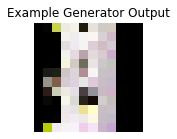

In [237]:
# load generator
'''
generator.compile(optimizer=Adam(lr=0.0008), # per Foster, 2017 RMSprop(lr=0.0008)
                          loss=binary_crossentropy,
                          metrics=['accuracy'])
generator = tf.keras.models.load_model('/data/output/models/dwarfganWGANGPR02/generator-2021-04-04_025322.h5')
'''
# generate new example of learned representation in latent space
try:
    generator
except NameError:
    #get latest generator model save file
    folder = pathlib.Path(f'{out_model_dir}/{model_name}')
    saves = list(folder.glob('generator*'))
    latest = max(saves, key=os.path.getctime)
    #load latest generator save file
    generator = tf.keras.models.load_model(latest)
        
noise = np.random.normal(0, 1, (1, LATENT_DIM))
res = np.array(generator(noise, training=False)).astype('uint8')

#Rescale
res = res.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Visualize result
plt.figure(figsize=(2, 2))
plt.imshow(res)
plt.title(f'Example Generator Output')
plt.axis('off')